In [20]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
with openmc.StatePoint('results/statepoint.1000.h5') as sp:
    r_grid = sp.get_tally(name="nufission").filters[0].mesh.r_grid
    nufission = sp.get_tally(name="nufission").get_reshaped_data(expand_dims=False).squeeze()
    reshaped_nufission = sp.get_tally(name="nufission").get_reshaped_data(expand_dims=True).squeeze()
    f_ij = sp.get_tally(name="f_ij").get_reshaped_data(expand_dims=False).squeeze()
    fij_tally = sp.get_tally(name="f_ij")
    keff = sp.keff

In [21]:
print(f"MC keff={keff}")
print(f"nu-fission={nufission}")
print(f"nu-fission keff={nufission.sum()}")

MC keff=1.02772+/-0.00007
nu-fission=[3.11273730e-06 2.18377157e-05 5.91786363e-05 1.14977480e-04
 1.88967912e-04 2.81830808e-04 3.92120286e-04 5.21425473e-04
 6.68474383e-04 8.31587478e-04 1.01293311e-03 1.21013974e-03
 1.42387821e-03 1.65402747e-03 1.90095358e-03 2.16049380e-03
 2.43625046e-03 2.72705617e-03 3.02896327e-03 3.34418598e-03
 3.67240895e-03 4.01261950e-03 4.36487803e-03 4.72860866e-03
 5.09679681e-03 5.47973070e-03 5.86927447e-03 6.26990278e-03
 6.67139285e-03 7.07619329e-03 7.49428491e-03 7.91096616e-03
 8.33176111e-03 8.75606702e-03 9.18118158e-03 9.60818556e-03
 1.00309504e-02 1.04581306e-02 1.08791292e-02 1.12939472e-02
 1.17131578e-02 1.21242093e-02 1.25261947e-02 1.29259628e-02
 1.33220598e-02 1.37072089e-02 1.40813439e-02 1.44506839e-02
 1.48020914e-02 1.51349836e-02 1.54609023e-02 1.57792271e-02
 1.60710180e-02 1.63571196e-02 1.66310886e-02 1.68783217e-02
 1.71121665e-02 1.73321013e-02 1.75296173e-02 1.77058988e-02
 1.78618486e-02 1.79922359e-02 1.81082309e-02 1.

In [22]:
print(f"MC computed keff:        {keff:.5f}")
print(f"keff from nufission sum: {np.sum(nufission):.5f}")
print(f"keff from f_ij sum:      {np.sum(f_ij):.5f}")

MC computed keff:        1.02772+/-0.00007
keff from nufission sum: 1.02767
keff from f_ij sum:      1.02767


Text(0.5, 1.0, '$f_{i,f}$ matrix with non-zero $\\nu\\Sigma_f$')

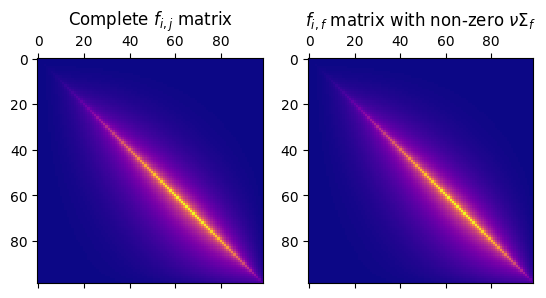

In [23]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(f_ij, cmap='plasma', origin='upper')
ax[0].set_title(r'Complete $f_{i,j}$ matrix')
ax[1].matshow(f_ij[nufission != 0, :][:, nufission != 0], cmap='plasma', origin='upper')
ax[1].set_title(r'$f_{i,f}$ matrix with non-zero $\nu\Sigma_f$')

Dominant eigenvalue: 1.02772e+00


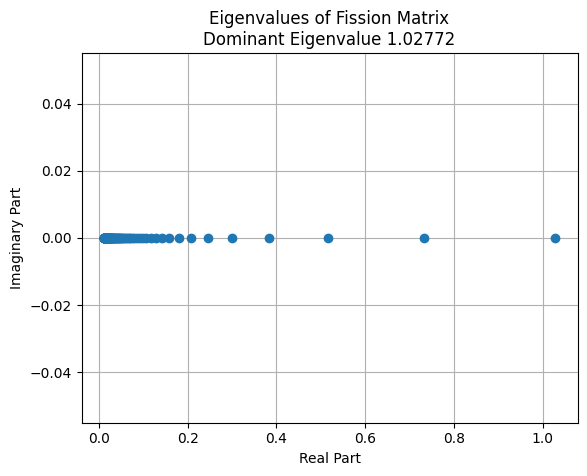

In [ ]:
fixed_fij = f_ij[nufission != 0, :][:, nufission != 0]
p_j = nufission[nufission != 0] / keff.n
values, vectors = np.linalg.eig(fixed_fij / p_j)
values = np.sort(values)[::-1]
vectors = vectors[:, np.argsort(np.abs(values))][:, ::-1]
print(f"Dominant eigenvalue: {np.max(np.abs(values)):.5e}")
fig, ax = plt.subplots(1, 1)
ax.plot(np.real(values), np.imag(values), 'o')
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_title(f'Eigenvalues of Fission Matrix\nDominant Eigenvalue {np.max(np.abs(values)):.5f}')
ax.grid()
plt.show()

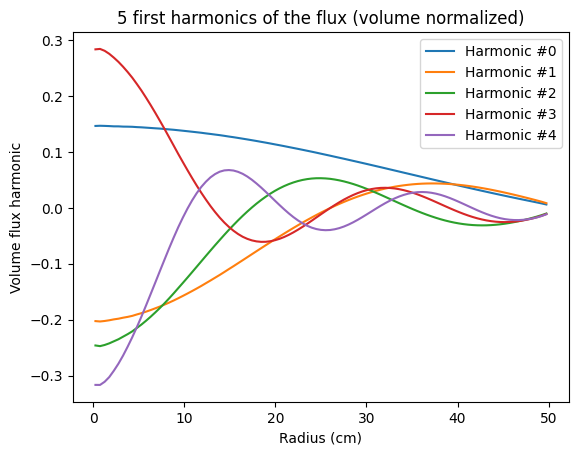

In [ ]:
p = Path("harmonics")
p.mkdir(exist_ok=True)
v_grid = r_grid[1:]**3 * 4/3 * np.pi - r_grid[:-1]**3 * 4/3 * np.pi
fig, ax = plt.subplots(1, 1)
for i in range(5):
    value = np.real(values[i])
    vector = np.real(vectors[:, i]) / v_grid
    if i == 0:
        vector = np.abs(vector)

    midpoints = (r_grid[:-1] + r_grid[1:]) / 2
    ax.plot(midpoints, vector / np.linalg.norm(vector), "-", label=f"Harmonic #{i}")
ax.set_title("5 first harmonics of the flux (volume normalized)")
ax.set_ylabel("Volumic flux harmonic")
ax.set_xlabel("Radius (cm)")
ax.legend()
plt.show()